###1. Criando uma Rede Neural

In [1]:
import torch
import numpy as np
from torch import nn

In [2]:
class LineNetwork(nn.Module):

    # Inicialização
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 1)
        )

    # Como a rede computa
    def forward(self, x):
        return self.layers(x)

###2. Preparando a infraestrutura de dados

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [4]:
class AlgebraicDataset(Dataset):
  def __init__(self, f, interval, nsamples):
    X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
    self.data = [(x, f(x)) for x in X]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

line = lambda x: 2*x + 3
interval = [-10, 10]
train_nsamples = 1000
test_nsamples = 100

train_dataset = AlgebraicDataset(line, interval, train_nsamples)
test_dataset = AlgebraicDataset(line, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_nsamples, shuffle=True)

###3. Hiperparâmentros de Otimização

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = LineNetwork().to(device)

Using cpu device


In [6]:
# Função de perda (loss function)
# Erro quadrático médio (Mean Squared Error)
lossfunc = nn.MSELoss()

# Gradiente Descendente Estocástico
# SGD = Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# taxa de aprendizado lr = learning rate


In [7]:
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0
  for X, y in dataloader:
    X = X.unsqueeze(1).float().to(device)
    y = y.unsqueeze(1).float().to(device)

    pred = model(X)
    loss = lossfunc(pred, y)

    # zera os gradientes acumulados
    optimizer.zero_grad()

    # computa os gradientes
    loss.backward()

    # anda, de fato na direção que reduz o erro local
    optimizer.step()

    # loss é um tensor, item para obter o float
    cumloss += loss.item()

  return cumloss / len(dataloader)


def test(model, dataloader, lossfunc):
  model.eval()

  cumloss = 0.0
  with torch.no_grad():
    for X, y in dataloader:
      X = X.unsqueeze(1).float().to(device)
      y = y.unsqueeze(1).float().to(device)

      pred = model(X)
      loss = lossfunc(pred, y)

      cumloss += loss.item()

  return cumloss / len(dataloader)

###4. Treinando a Rede

In [8]:
import matplotlib.pyplot as plt

Epoch: 0 | Train loss: 284.2523193359375


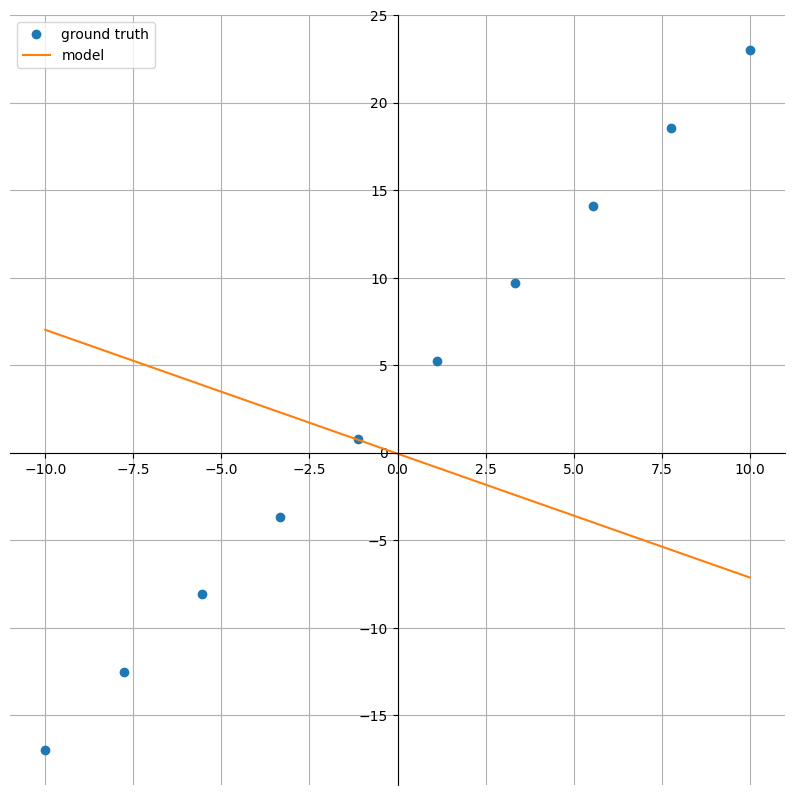

Epoch: 10 | Train loss: 79.87129974365234


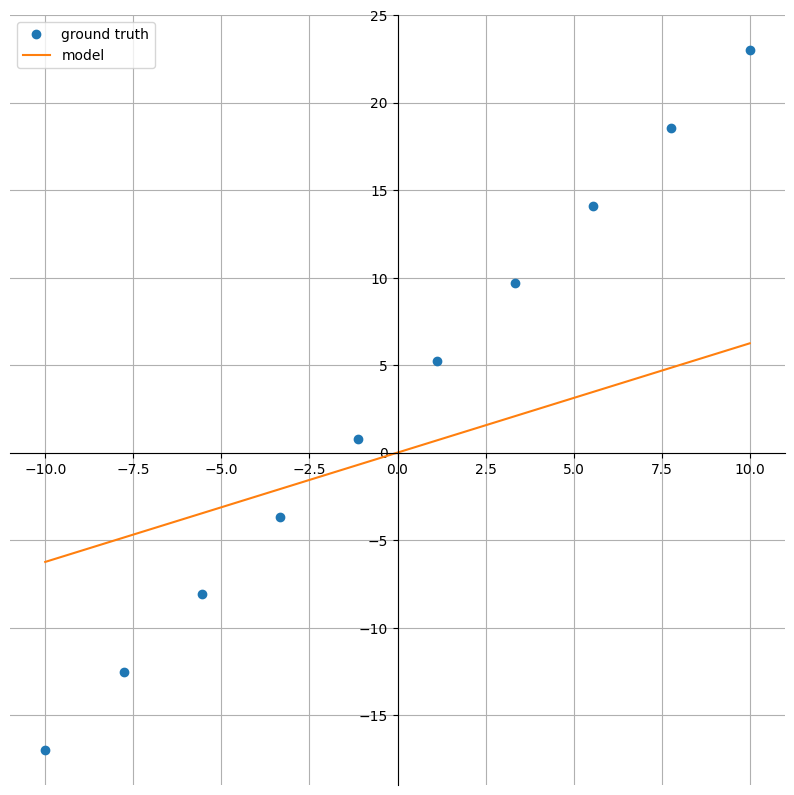

Epoch: 20 | Train loss: 26.960561752319336


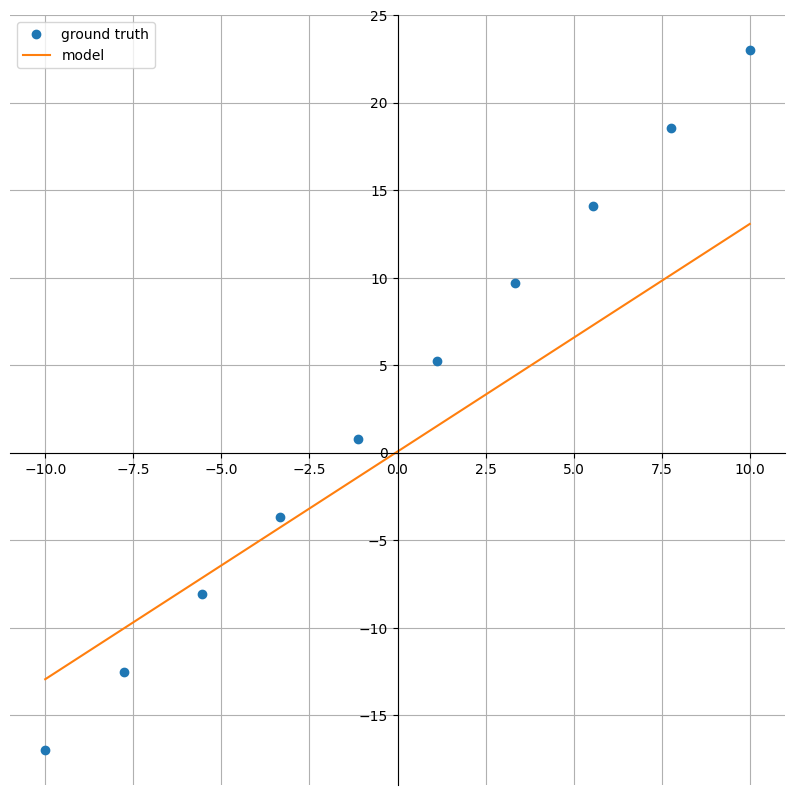

Epoch: 30 | Train loss: 13.079782485961914


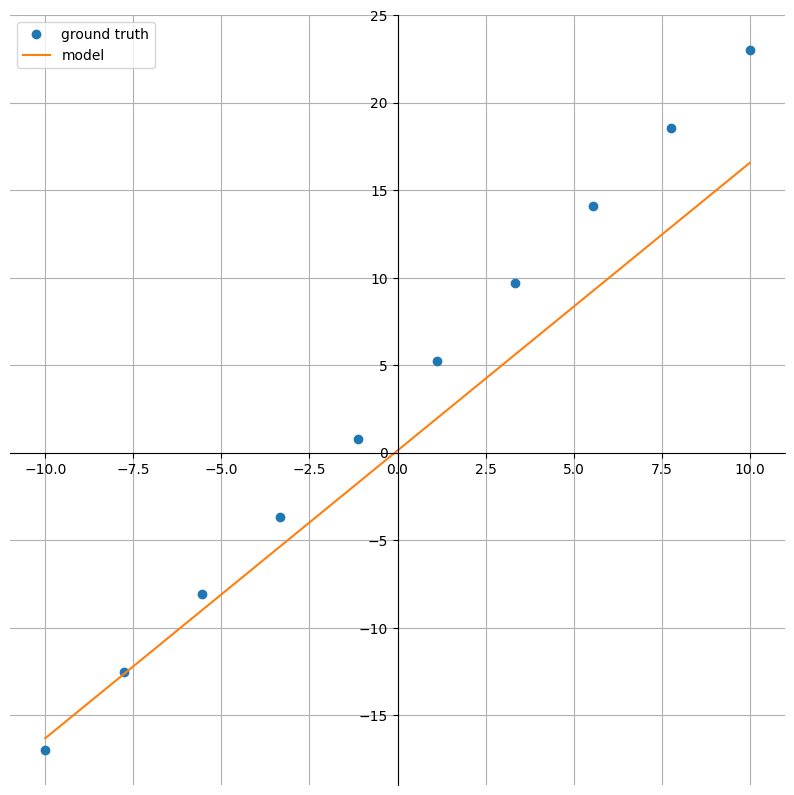

Epoch: 40 | Train loss: 9.263237953186035


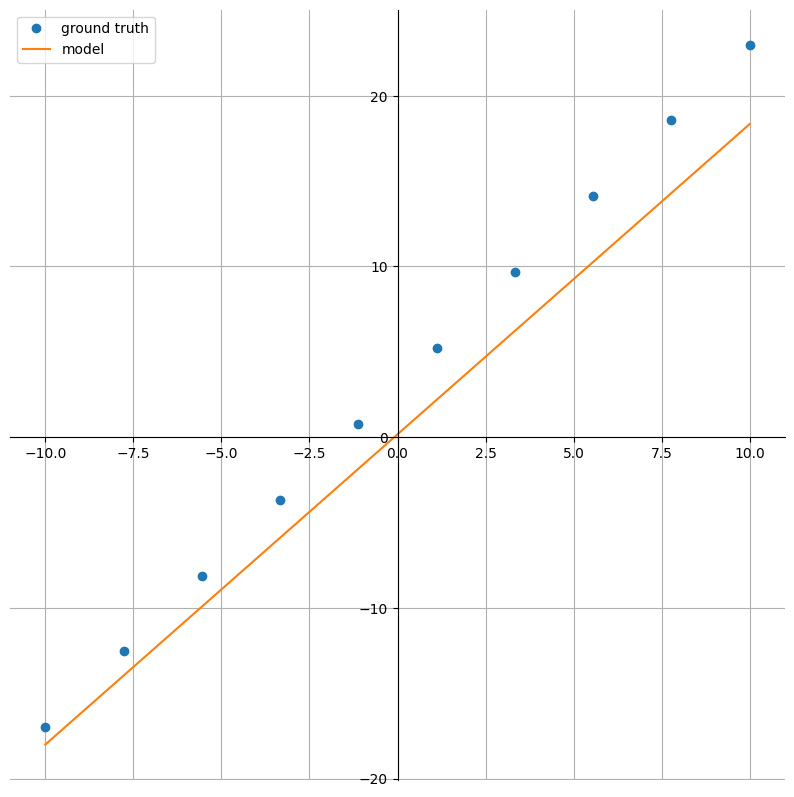

Epoch: 50 | Train loss: 8.04874324798584


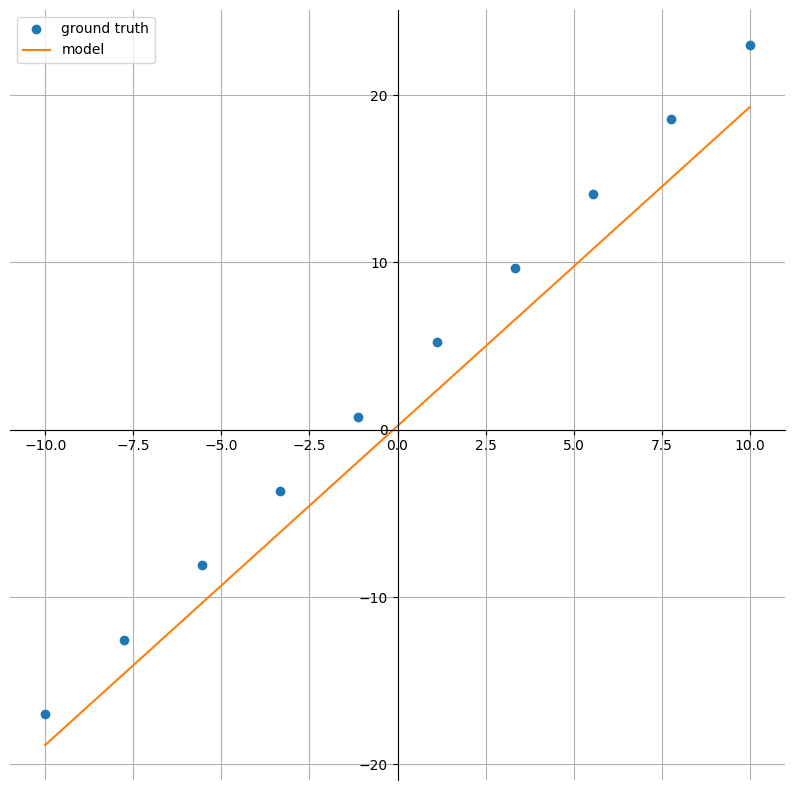

Epoch: 60 | Train loss: 7.5136399269104


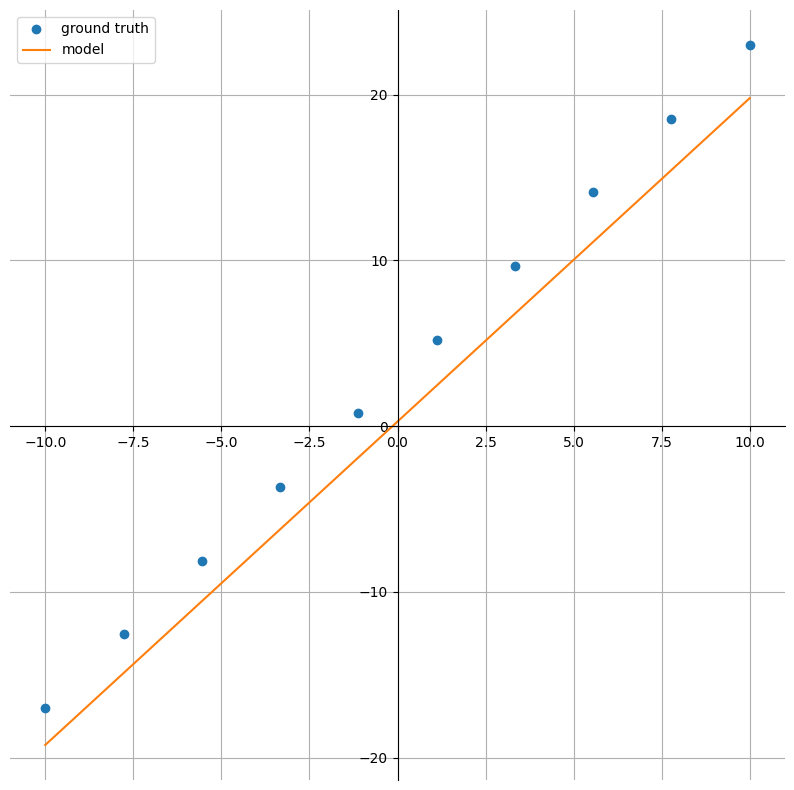

Epoch: 70 | Train loss: 7.162274360656738


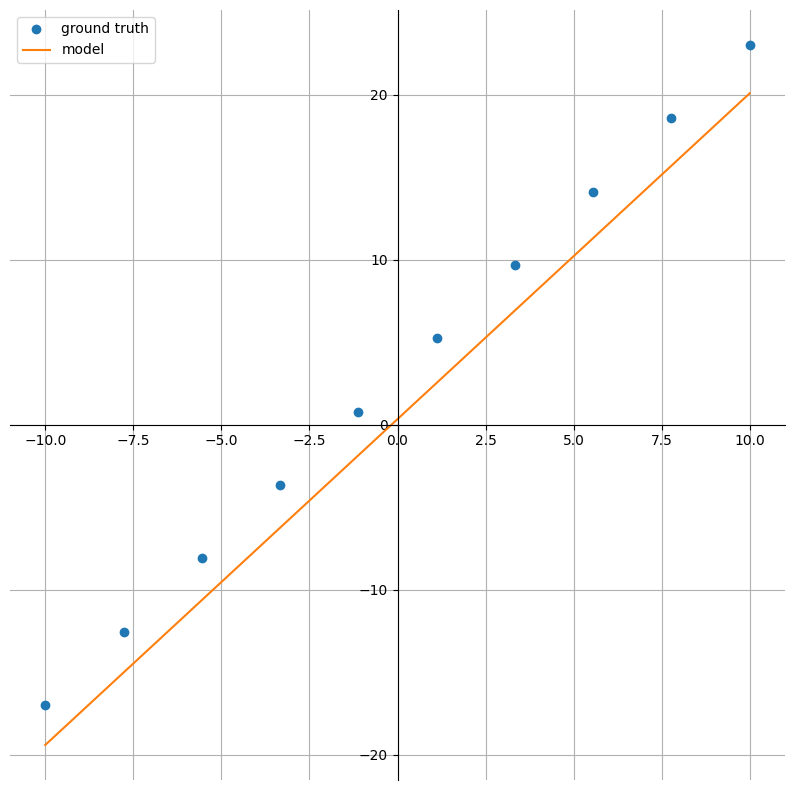

Epoch: 80 | Train loss: 6.866621971130371


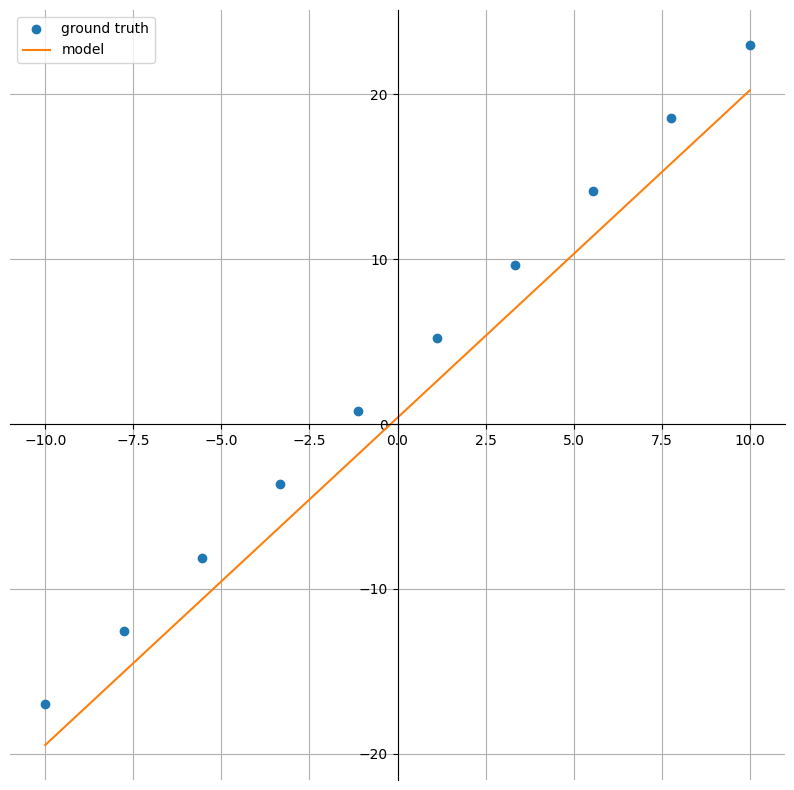

Epoch: 90 | Train loss: 6.593369960784912


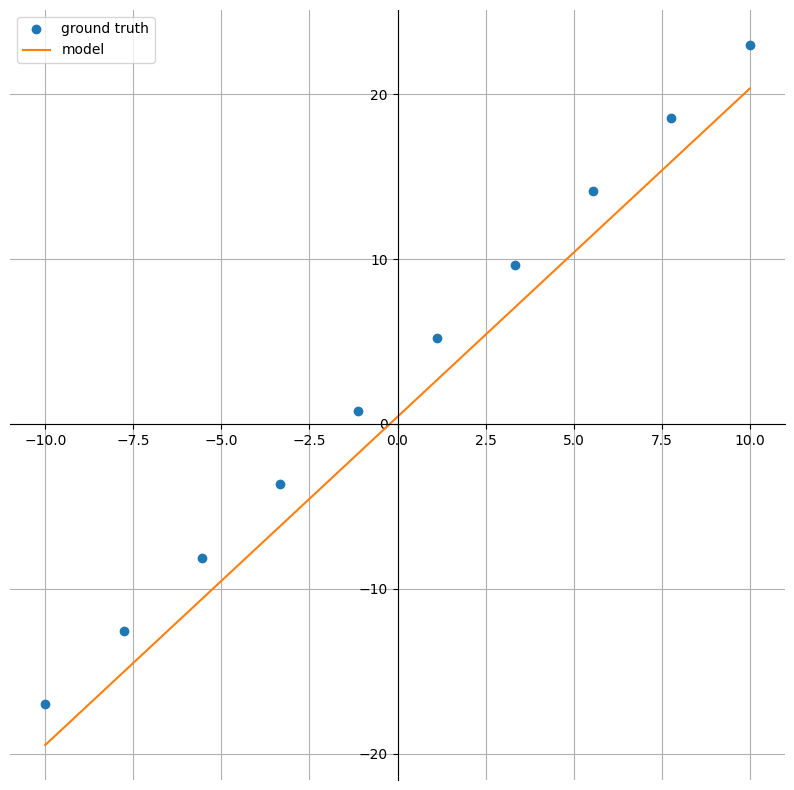

Epoch: 100 | Train loss: 6.333625793457031


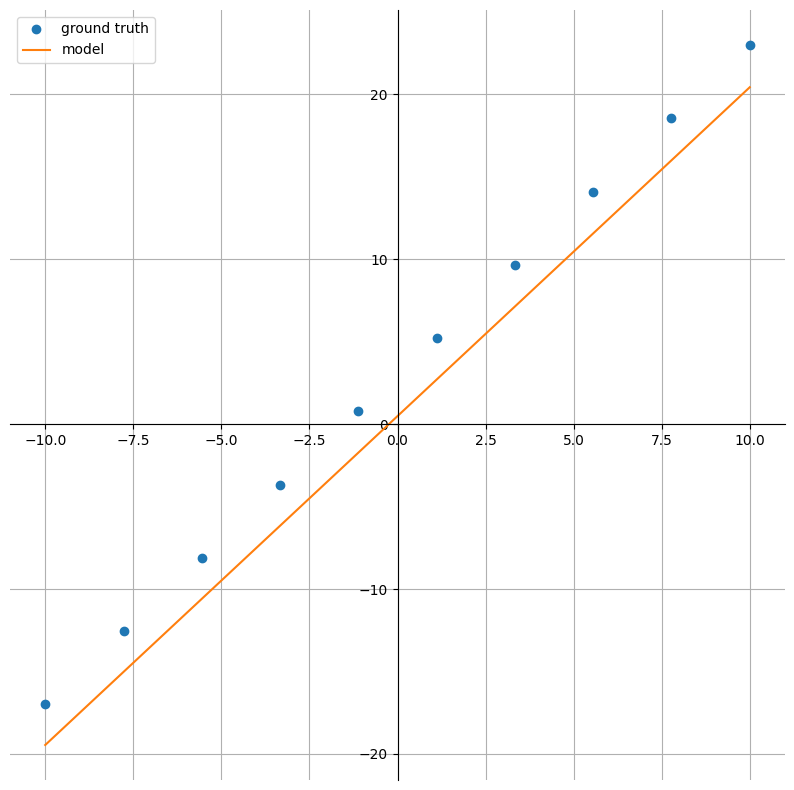

Epoch: 110 | Train loss: 6.084792613983154


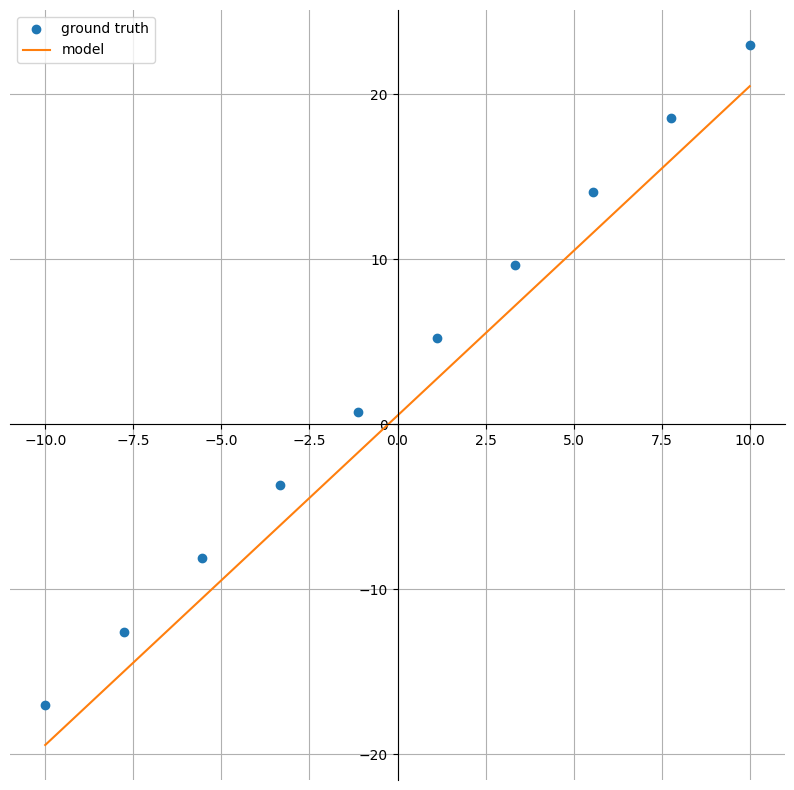

Epoch: 120 | Train loss: 5.845911979675293


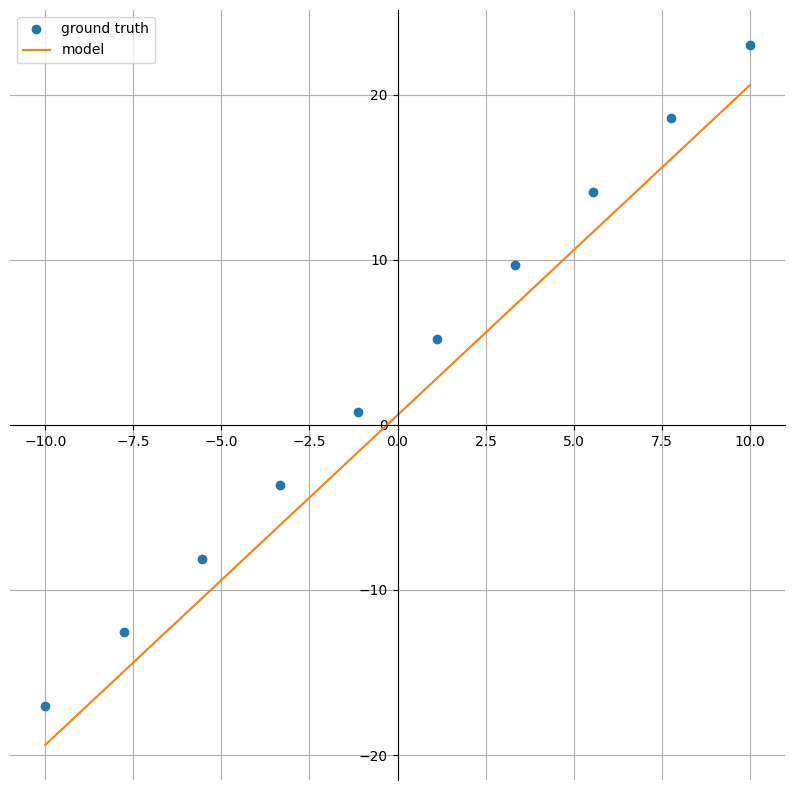

Epoch: 130 | Train loss: 5.616451740264893


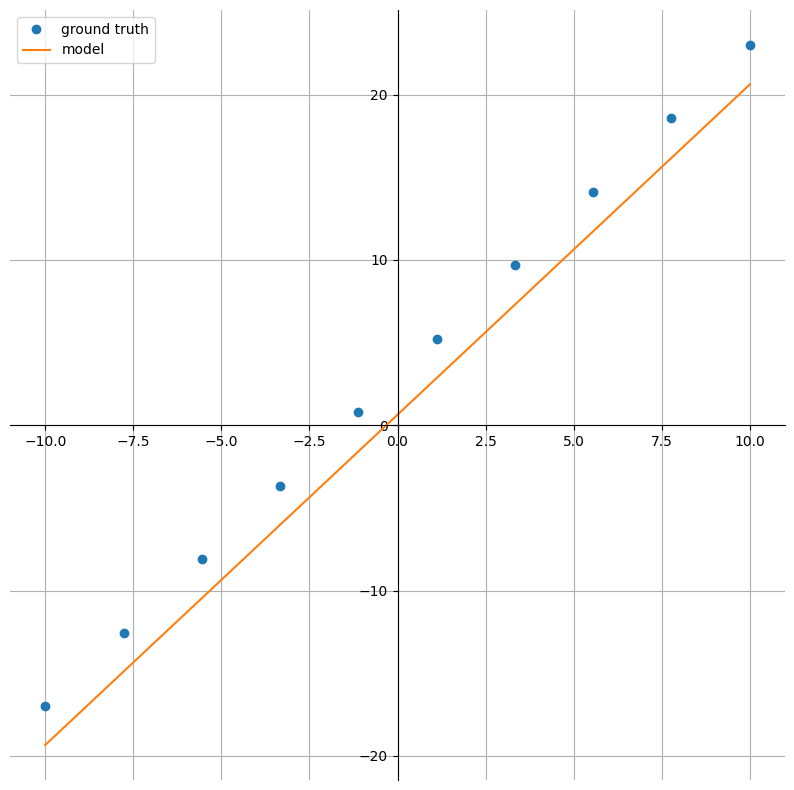

Epoch: 140 | Train loss: 5.396012306213379


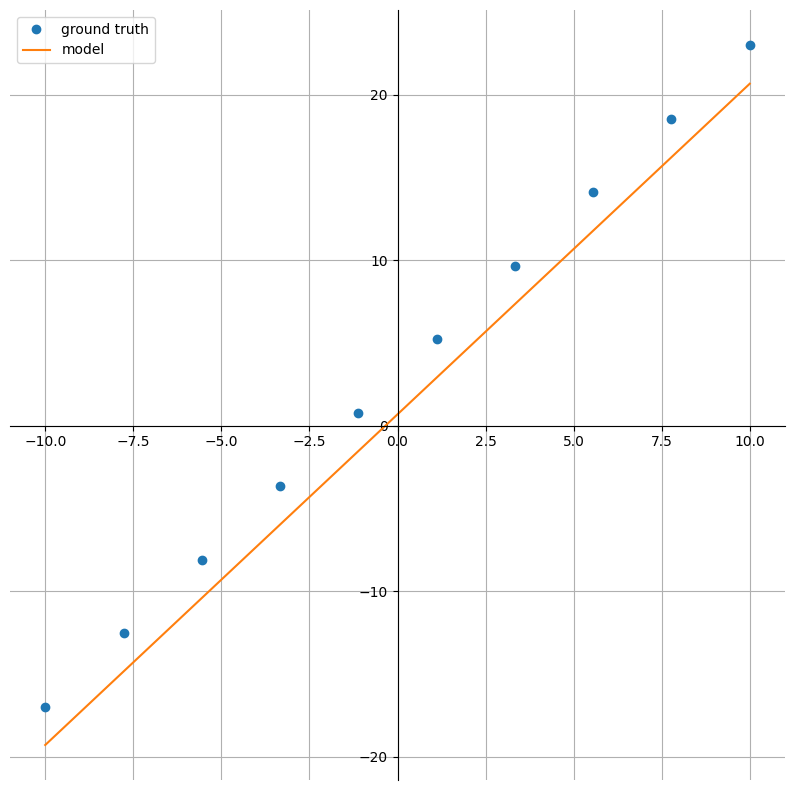

Epoch: 150 | Train loss: 5.1842265129089355


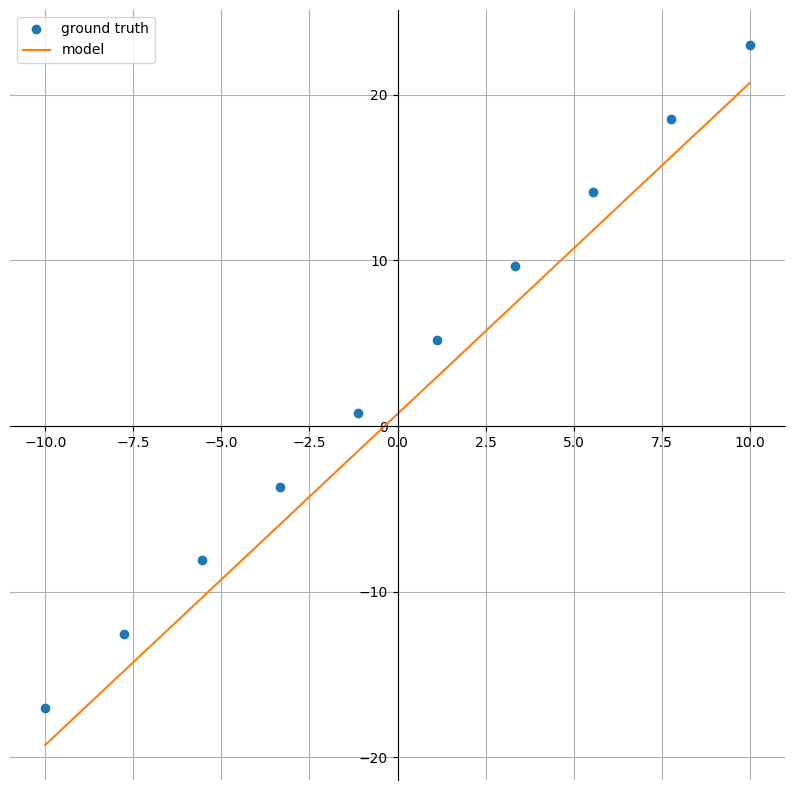

Epoch: 160 | Train loss: 4.9807538986206055


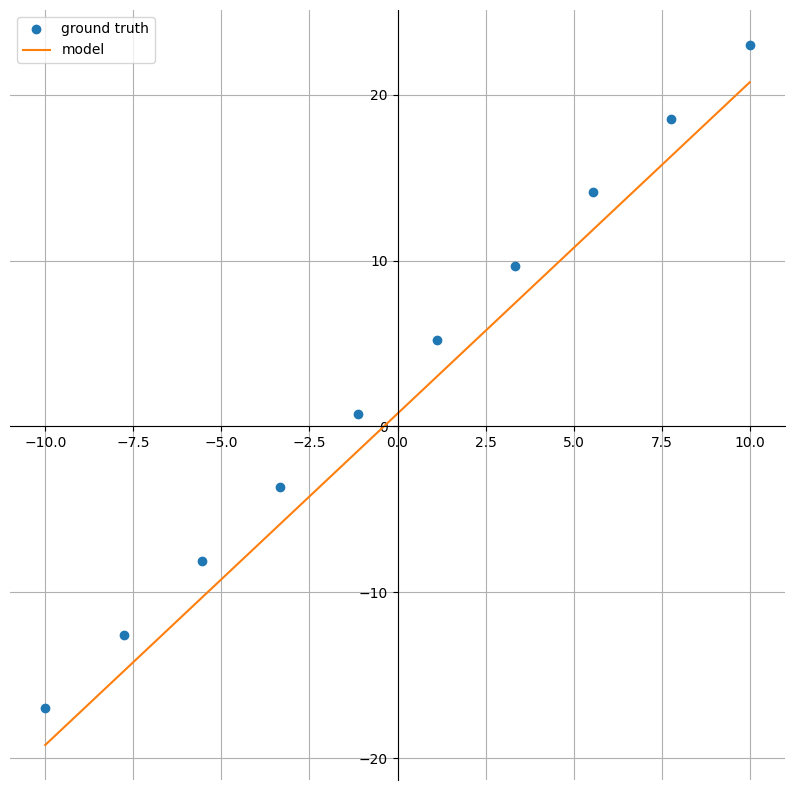

Epoch: 170 | Train loss: 4.785266876220703


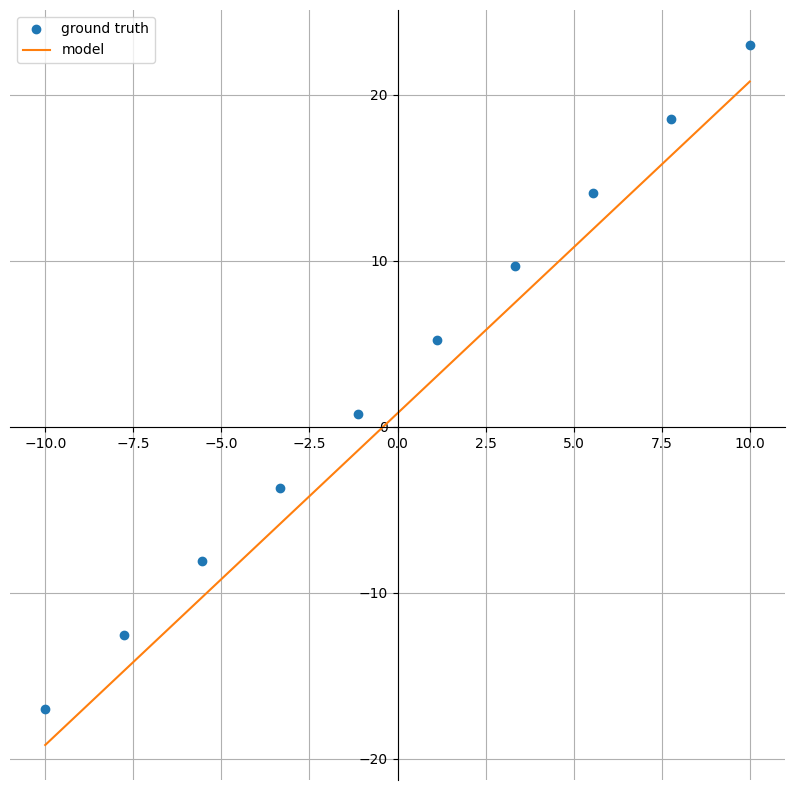

Epoch: 180 | Train loss: 4.597453594207764


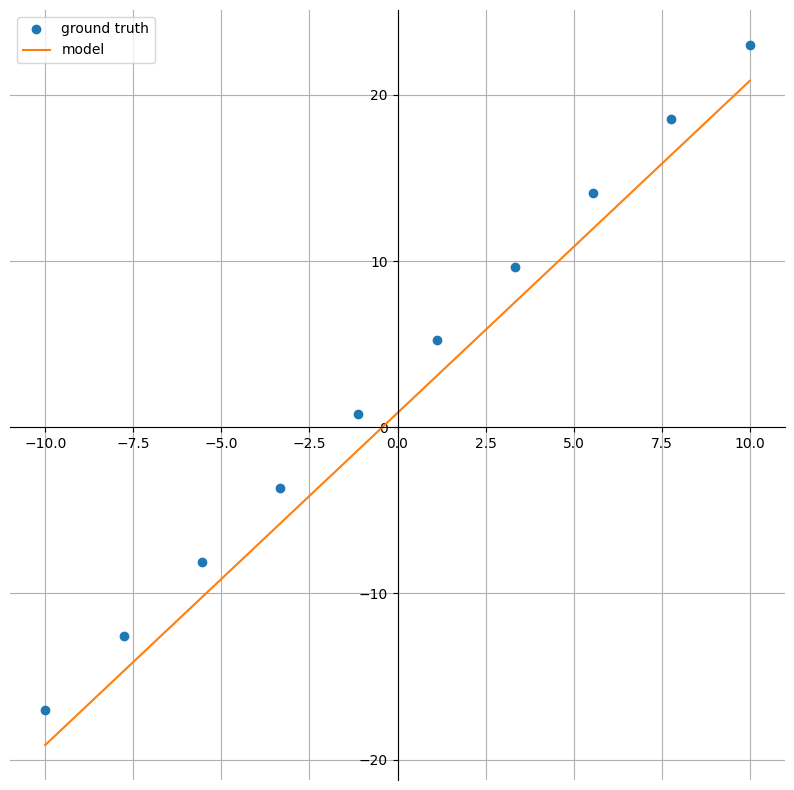

Epoch: 190 | Train loss: 4.417011260986328


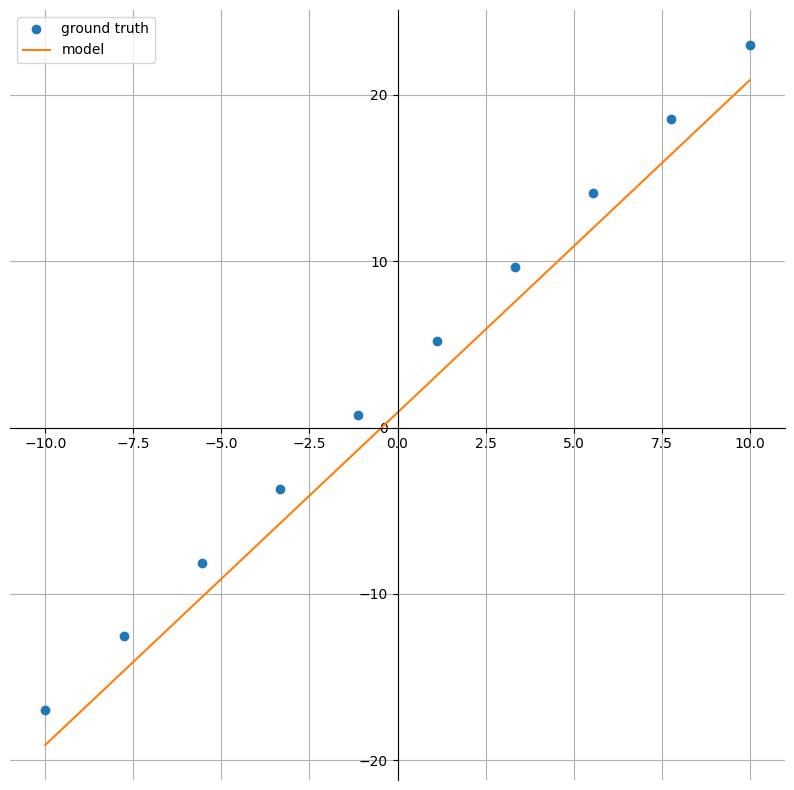

Epoch: 200 | Train loss: 4.243650436401367


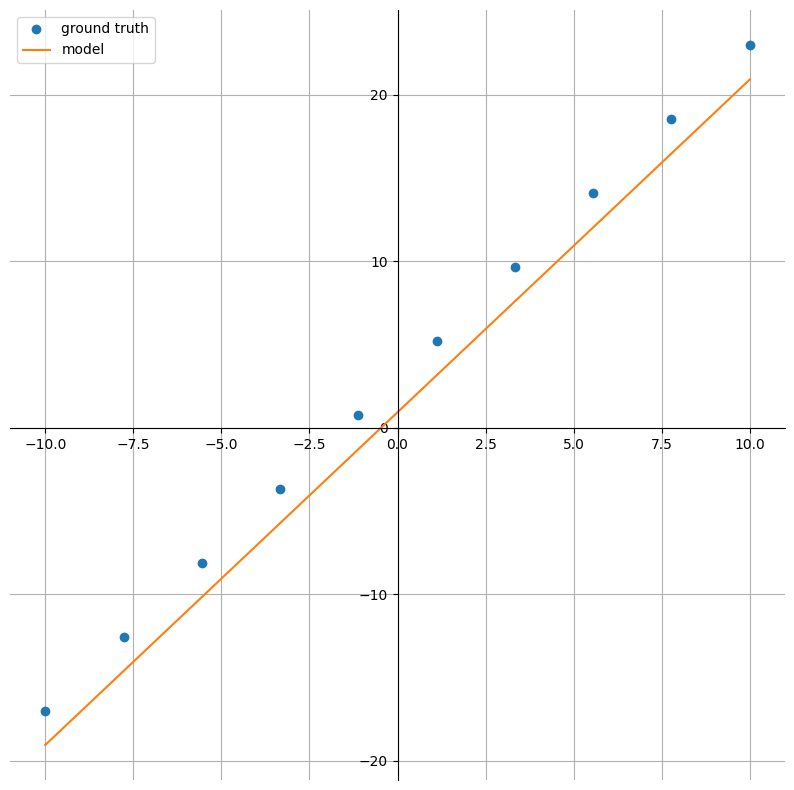

Test loss: 4.225515365600586


In [9]:
# Para visualizar

def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  ax.plot(samples, pred.cpu(), label="model")
  plt.legend()
  plt.show()


epochs = 201
for t in range(epochs):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t % 10 == 0:
    print(f"Epoch: {t} | Train loss: {train_loss}")
    plot_comparinson(line, model)

test_loss = test(model, test_dataloader, lossfunc)
print(f"Test loss: {test_loss}")

###5. Outro Exemplo

In [20]:
class MultiLayerNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, 1)
    )

  def forward(self, x):
    return self.layers(x)


In [21]:
multimodel = MultiLayerNetwork().to(device)

In [22]:
from math import cos

f = lambda x: cos(x/2)

train_dataset = AlgebraicDataset(f, interval, train_nsamples)
test_dataset = AlgebraicDataset(f, interval, test_nsamples)

train_dataloader = DataLoader(train_dataset, train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, test_nsamples, shuffle=True)

lossfunc = nn.MSELoss()
optimizer = torch.optim.SGD(multimodel.parameters(), lr=1e-3)



Epoch: 0 | Train loss: 0.0003405870811548084


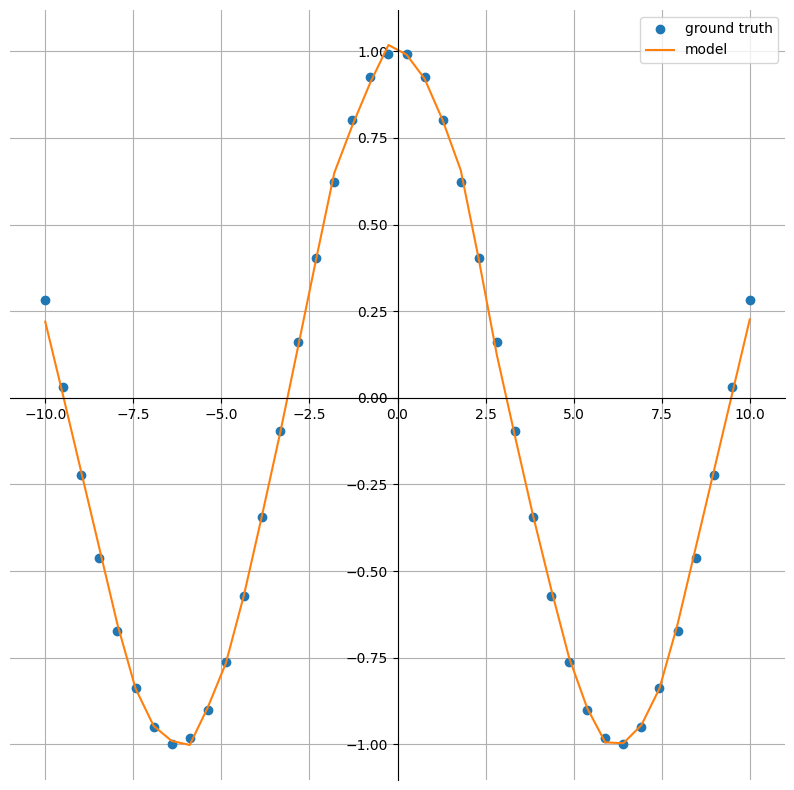

Epoch: 100 | Train loss: 0.0003363082942087203


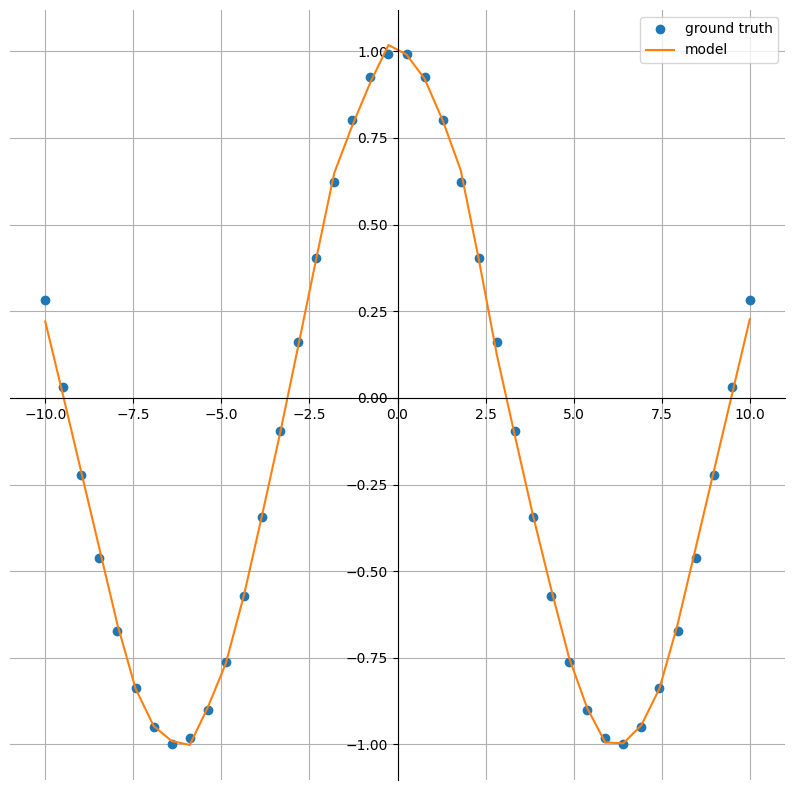

Epoch: 200 | Train loss: 0.0003321529657114297


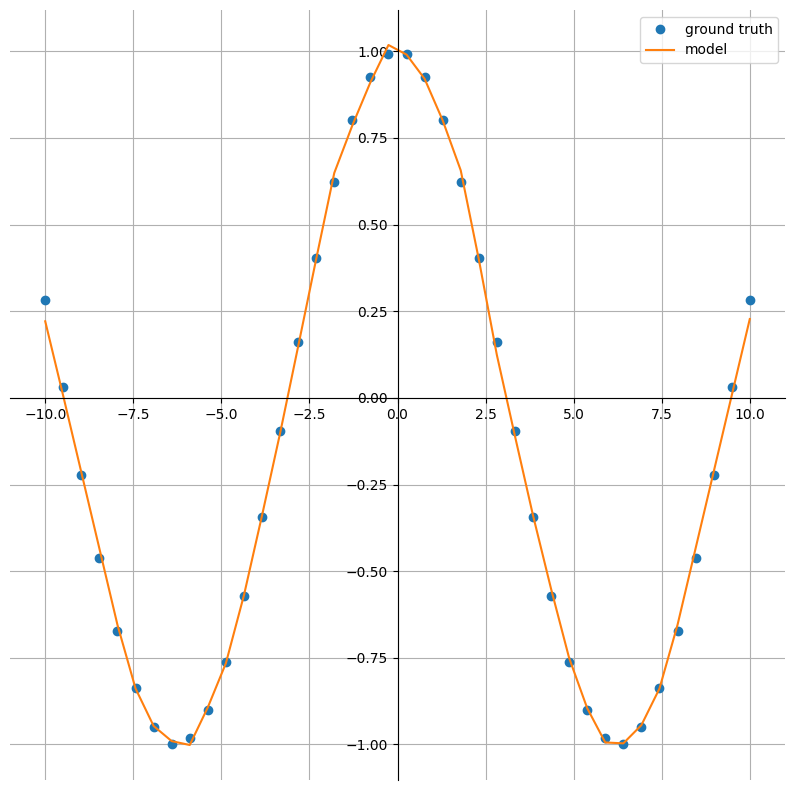

Test loss: 0.00036615534918382764


In [26]:
epochs = 201
for t in range(epochs):
  train_loss = train(multimodel, train_dataloader, lossfunc, optimizer)
  if t % 100 == 0:
    print(f"Epoch: {t} | Train loss: {train_loss}")
    plot_comparinson(f, multimodel, nsamples=40)

test_loss = test(multimodel, test_dataloader, lossfunc)
print(f"Test loss: {test_loss}")